In [75]:
#Python version
!python --version

Python 3.8.5


In [76]:
#Install uninstalled modules, comment if it's already installed

#!pip install stable-baselines[mpi]
#!pip install ipykernel
#!pip install MetaTrader5==5.0.34
#!pip install gym
#!pip install gym-anytrading
#!pip install tensorflow==1.15.0
#!pip install quantstats

In [77]:
#Import needed modules
import gym
import gym_anytrading
from gym_anytrading.datasets import FOREX_EURUSD_1H_ASK

import numpy as np
import quantstats as qs

from stable_baselines.a2c import A2C
from stable_baselines.common.vec_env import DummyVecEnv
from stable_baselines.common.policies import MlpLstmPolicy

import matplotlib.pyplot as plt
import pandas as pd

import random, datetime, os, copy
import MetaTrader5 as mt5

In [107]:
#Trading Account Parameter
account = 647545 #Account number
password = "QpjpAGkK" #Password number
server = "FBS-Demo" #Server name
path = "C:\Program Files\FBS MetaTrader 5\terminal64.exe" #path of Metatrader5 director

mt5.initialize(
   path = path,                     # path to the MetaTrader 5 terminal EXE file
   login = account,          # account number
   password = password,      # password
   server = server,          # server name as it is specified in the terminal
   #timeout = TIMEOUT,       # timeout
   portable = False          # portable mode
   )

# display data on the MetaTrader 5 package
print("MetaTrader5 package author: ",mt5.__author__)
print("MetaTrader5 package version: ",mt5.__version__)

# establish connection to the MetaTrader 5 terminal
if not mt5.initialize():
    print("initialize failed, error code =",mt5.last_error())
    mt5.shutdown()
else:
    print("MetaTrader5 Initialized!")

#weekdays = ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday"]

# Initialize Metatrader on a certain day
#if datetime.date.isoweekday() != 6 or 7:
    # now connect to another trading account specifying the password
authorized=mt5.login(account, password, server)
if authorized:
    # display trading account data 'as is'
    print("Metatrader5 has been authorized!")
    Acc_Info = pd.DataFrame(list(account_info_dict.items()),columns=['property','value'])
    print("account_info() as dataframe:")
    print(Acc_Info)
else:
    print("Metatrader5 hasn't authorized, error code: {}".format(mt5.last_error()))

MetaTrader5 package author:  MetaQuotes Software Corp.
MetaTrader5 package version:  5.0.34
MetaTrader5 Initialized!
Metatrader5 has been authorized!
account_info() as dataframe:
              property             value
0                login            647545
1           trade_mode                 0
2             leverage              1000
3         limit_orders               100
4       margin_so_mode                 0
5        trade_allowed              True
6         trade_expert              True
7          margin_mode                 2
8      currency_digits                 2
9           fifo_close             False
10             balance            100000
11              credit                 0
12              profit                 0
13              equity            100000
14              margin                 0
15         margin_free            100000
16        margin_level                 0
17      margin_so_call                40
18        margin_so_so                20
1

In [117]:
#Extract Account info from dataframe
leverage = Acc_Info.loc[2, "value"]
equity = Acc_Info.loc[13, "value"]
margin_free = Acc_Info.loc[15, "value"]

print(leverage)
print(equity)
print(margin_free)

1000
100000.0
100000.0



env information:
> shape: (10, 2)
> df.shape: (6225, 5)
> prices.shape: (120,)
> signal_features.shape: (120, 2)
> max_possible_profit: 1.0459258410615082


> possible action: Discrete(2)
> observation space: Box(-inf, inf, (10, 2), float32)


> signal features:  [[ 1.05227e+00  0.00000e+00]
 [ 1.05282e+00  5.50000e-04]
 [ 1.05281e+00 -1.00000e-05]
 [ 1.05240e+00 -4.10000e-04]
 [ 1.05220e+00 -2.00000e-04]
 [ 1.05226e+00  6.00000e-05]
 [ 1.05193e+00 -3.30000e-04]
 [ 1.05161e+00 -3.20000e-04]
 [ 1.05172e+00  1.10000e-04]
 [ 1.05162e+00 -1.00000e-04]
 [ 1.04899e+00 -2.63000e-03]
 [ 1.04877e+00 -2.20000e-04]
 [ 1.04815e+00 -6.20000e-04]
 [ 1.04790e+00 -2.50000e-04]
 [ 1.04663e+00 -1.27000e-03]
 [ 1.04666e+00  3.00000e-05]
 [ 1.04738e+00  7.20000e-04]
 [ 1.04725e+00 -1.30000e-04]
 [ 1.04705e+00 -2.00000e-04]
 [ 1.04668e+00 -3.70000e-04]
 [ 1.04619e+00 -4.90000e-04]
 [ 1.04610e+00 -9.00000e-05]
 [ 1.04610e+00  0.00000e+00]
 [ 1.04552e+00 -5.80000e-04]
 [ 1.04637e+00  8.50000e-04]
 [ 1.04579

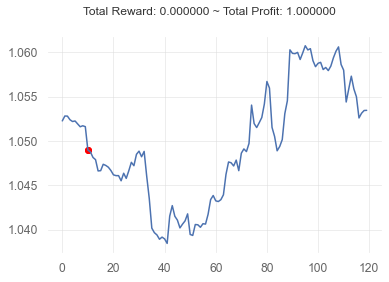

In [41]:
env = gym.make('forex-v0',
               df = FOREX_EURUSD_1H_ASK,
               window_size = 10,
               frame_bound = (10, 120), #Max 6225 Rows of data
               unit_side = 'right')

seed = 42
env.seed(seed)
eps = np.finfo(np.float32).eps.item()

print()
print("env information:")
print("> shape:", env.shape)
print("> df.shape:", env.df.shape)
print("> prices.shape:", env.prices.shape)
print("> signal_features.shape:", env.signal_features.shape)
print("> max_possible_profit:", env.max_possible_profit())
print("\n")
print("> possible action:", env.action_space)
print("> observation space:", env.observation_space)
print("\n")
print("> signal features: ", env.signal_features)

env.reset() # Uncomment if you need it.
env.render()


In [42]:
print(env.df)
print("\n")
env.df.info()

                        Open     High      Low    Close        Volume
Time                                                                 
2017-01-01 22:00:00  1.05236  1.05253  1.05221  1.05227  1.435400e+08
2017-01-01 23:00:00  1.05227  1.05426  1.05226  1.05282  2.531400e+08
2017-02-01 00:00:00  1.05283  1.05283  1.05268  1.05281  1.314000e+08
2017-02-01 01:00:00  1.05282  1.05286  1.05225  1.05240  2.739400e+08
2017-02-01 02:00:00  1.05239  1.05240  1.05164  1.05220  2.581400e+08
...                      ...      ...      ...      ...           ...
2017-12-29 17:00:00  1.20224  1.20257  1.20191  1.20218  9.283300e+09
2017-12-29 18:00:00  1.20218  1.20242  1.20122  1.20139  7.366750e+09
2017-12-29 19:00:00  1.20139  1.20144  1.20073  1.20096  7.205770e+09
2017-12-29 20:00:00  1.20098  1.20109  1.19978  1.19982  6.679810e+09
2017-12-29 21:00:00  1.19984  1.20130  1.19931  1.20075  4.885530e+09

[6225 rows x 5 columns]


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 6225 entri

In [43]:
'''
def my_process_data(df, window_size, frame_bound):
    start = frame_bound[0] - window_size
    end = frame_bound[1]
    prices = df.loc[:, 'Low'].to_numpy()[start:end]
    signal_features = df.loc[:, ['Open', 'High', 'Low', 'Close', 'Volume']].to_numpy()[start:end]
    return prices, signal_features

prices, signal_features = my_process_data(
            df = FOREX_EURUSD_1H_ASK,
            window_size = 10,
            frame_bound = (10, 800), #Max 6225 Rows of data
)

print(prices)
print("\n")
print(signal_features)
'''

'\ndef my_process_data(df, window_size, frame_bound):\n    start = frame_bound[0] - window_size\n    end = frame_bound[1]\n    prices = df.loc[:, \'Low\'].to_numpy()[start:end]\n    signal_features = df.loc[:, [\'Open\', \'High\', \'Low\', \'Close\', \'Volume\']].to_numpy()[start:end]\n    return prices, signal_features\n\nprices, signal_features = my_process_data(\n            df = FOREX_EURUSD_1H_ASK,\n            window_size = 10,\n            frame_bound = (10, 800), #Max 6225 Rows of data\n)\n\nprint(prices)\nprint("\n")\nprint(signal_features)\n'

info: {'total_reward': -9.99999999999891, 'total_profit': 0.9929717850111106, 'position': 0}


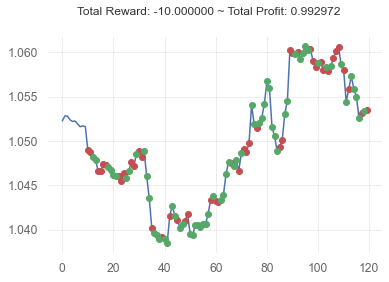

In [44]:
# Based on random actions

observation = env.reset()
while True:
    action = env.action_space.sample()
    observation, reward, done, info = env.step(action)
    # env.render()
    if done:
        print("info:", info)
        break

plt.cla()
env.render_all()
plt.show()